<a href="https://colab.research.google.com/github/kahram-y/first-repository/blob/master/WrapUp/portfolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install finance-datareader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 kB 3.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import FinanceDataReader as fdr

In [ ]:
# 1. 종목 설정 (삼성생명, 삼성화재, DB손해보험, 현대해상, 한화생명)
# 각 코드에 맞게 이름을 매칭하여 나중에 보기 편하게 만듭니다.
ticker_dict = {
    '삼성생명': '032830',
    '삼성화재': '000810',
    'DB손해보험': '005830',
    '현대해상': '001450',
    '한화생명': '088350'
}

tickers = list(ticker_dict.values())
stock_names = list(ticker_dict.keys())

# 2. 데이터 불러오기
data = pd.DataFrame()
for t in tickers:
    # 2024년 전체 데이터를 기준으로 'Close(종가)' 컬럼만 가져옵니다.
    data[t] = fdr.DataReader(t, '2024-01-01', '2024-12-31')['Close']

# 컬럼명을 종목 코드가 아닌 한글 이름으로 변경 (가독성용)
data.columns = stock_names

print("--- 데이터 로드 완료 ---")
print(data.head())

--- 데이터 로드 완료 ---
             삼성생명    삼성화재  DB손해보험   현대해상  한화생명
Date                                          
2024-01-02  68200  260000   81600  30600  2755
2024-01-03  67000  253500   80900  30250  2675
2024-01-04  66200  250000   79200  29950  2625
2024-01-05  65500  248000   79100  30000  2575
2024-01-08  65100  248000   79200  29800  2520


In [ ]:
# --- 2. 일간 & 연간 수익률 계산 ---
daily_ret = data.pct_change()
annual_ret = daily_ret.mean() * 252
print("연간 평균 수익률:\n", annual_ret)

# --- 3. 연간 분산/공분산 (위험도) ---
daily_cov = daily_ret.cov()
annual_cov = daily_cov * 252
print("\n연간 공분산:\n", annual_cov)

연간 평균 수익률:
 삼성생명      0.439124
삼성화재      0.438907
DB손해보험    0.336207
현대해상     -0.165054
한화생명     -0.048720
dtype: float64

연간 공분산:
             삼성생명      삼성화재    DB손해보험      현대해상      한화생명
삼성생명    0.198105  0.126421  0.107193  0.083637  0.104931
삼성화재    0.126421  0.213896  0.134008  0.092998  0.102683
DB손해보험  0.107193  0.134008  0.194475  0.104986  0.099339
현대해상    0.083637  0.092998  0.104986  0.114300  0.082502
한화생명    0.104931  0.102683  0.099339  0.082502  0.138114


In [ ]:
# --- 4. 몬테카를로 시뮬레이션 ---
stocks = data.columns.tolist()  # 종목명 리스트
simulations = 10000
box = []
for i in range(simulations):
    w = np.random.random(len(stocks))
    w /= sum(w)
    ret = np.dot(w, annual_ret)
    risk = np.sqrt(np.dot(w.T, np.dot(annual_cov, w)))
    sharpe = ret / risk if risk > 0 else 0
    box.append([ret, risk, sharpe] + list(w))

# 결과 저장
cols = ['Returns', 'Risk', 'Sharpe'] + stocks
results = pd.DataFrame(box, columns=cols)
print("\nSimulation Results Sample:\n", results.head())


Simulation Results Sample:
     Returns      Risk    Sharpe      삼성생명      삼성화재    DB손해보험      현대해상  \
0  0.232130  0.349611  0.663967  0.408635  0.101295  0.176254  0.307210   
1  0.275963  0.356110  0.774936  0.293167  0.232595  0.203240  0.085866   
2  0.130076  0.335338  0.387894  0.095043  0.236200  0.131434  0.286593   
3  0.153309  0.338824  0.452473  0.232926  0.008659  0.287629  0.228147   
4  0.221545  0.348889  0.635002  0.334160  0.057260  0.295765  0.296752   

       한화생명  
0  0.006606  
1  0.185133  
2  0.250730  
3  0.242639  
4  0.016063  


In [ ]:
# --- 5. 최대 샤프 & 최소 리스크 포트폴리오 ---
# Sharpe나 Risk 컬럼에 NaN이 있으면 행을 제거합니다.
clean_results = results.dropna(subset=['Sharpe', 'Risk'])

# 2. 제거 후 데이터가 남아있는지 확인하고 계산합니다.
max_sharpe = results.loc[results['Sharpe'].idxmax()]
min_risk = results.loc[results['Risk'].idxmin()]
print("\nMax Sharpe Portfolio:\n", max_sharpe)
print("\nMin Risk Portfolio:\n", min_risk)


Max Sharpe Portfolio:
 Returns    0.419222
Risk       0.393819
Sharpe     1.064506
삼성생명       0.439615
삼성화재       0.425018
DB손해보험     0.120493
현대해상       0.001311
한화생명       0.013563
Name: 7553, dtype: float64

Min Risk Portfolio:
 Returns   -0.073753
Risk       0.319211
Sharpe    -0.231047
삼성생명       0.061460
삼성화재       0.008437
DB손해보험     0.015707
현대해상       0.560246
한화생명       0.354151
Name: 3989, dtype: float64


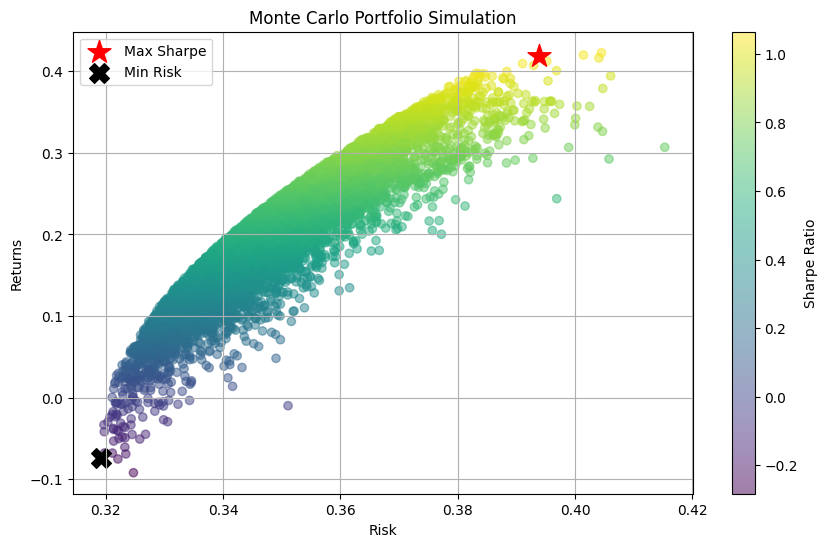

In [ ]:
# --- 6. 시각화 ---
plt.figure(figsize=(10,6))
plt.scatter(results['Risk'], results['Returns'], c=results['Sharpe'],
            cmap='viridis', alpha=0.5)
plt.colorbar(label='Sharpe Ratio')
plt.scatter(max_sharpe['Risk'], max_sharpe['Returns'],
            marker='*', color='r', s=300, label='Max Sharpe')
plt.scatter(min_risk['Risk'], min_risk['Returns'],
            marker='X', color='black', s=200, label='Min Risk')
plt.xlabel('Risk')
plt.ylabel('Returns')
plt.title('Monte Carlo Portfolio Simulation')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# --- 7. (선택) KOSPI 지수 기본 통계 ---
kospi = fdr.DataReader('KOSPI')
print("\nKOSPI Data Head:\n", kospi.head())
print("\nKOSPI Max Close:", kospi['Close'].max())
print("KOSPI Min Close:", kospi['Close'].min())


KOSPI Data Head:
               Open    High     Low   Close     Volume  Change  UpDown   Comp  \
Date                                                                           
2001-06-11  612.46  615.41  607.20  608.23  340123834 -0.0218       2 -13.55   
2001-06-12  605.36  611.88  603.91  607.15  319877548 -0.0018       2  -1.08   
2001-06-13  611.79  614.05  607.48  614.05  392415108  0.0114       1   6.90   
2001-06-14  612.96  623.37  610.36  613.75  420520519 -0.0005       2  -0.30   
2001-06-15  609.54  618.96  604.37  618.96  375830101  0.0085       1   5.21   

                   Amount           MarCap  
Date                                        
2001-06-11  1711354887650  213769808029580  
2001-06-12  1579309434050  213407866089170  
2001-06-13  1882785913600  215722300556140  
2001-06-14  2138122210150  215864633350565  
2001-06-15  1984248114150  217830955673590  

KOSPI Max Close: 4221.87
KOSPI Min Close: 468.76
